In [1]:
import pandas as pd
import numpy as np


file_path = 'reduced_material_data.csv'
data = pd.read_csv(file_path)

machine_1_data = data[data['device'] == 'export_warehouse_1']

machine_1_data['timestamp'] = pd.to_datetime(machine_1_data['timestamp'], dayfirst=True)

# Normalize the readings
mean_reading = machine_1_data['reading'].mean()
std_dev_reading = machine_1_data['reading'].std()
machine_1_data['normalized_reading'] = (machine_1_data['reading'] - mean_reading) / std_dev_reading
machine_1_data = machine_1_data.sort_values('timestamp').reset_index(drop=True)


C:\Users\kish9\AppData\Local\Temp\ipykernel_2232\2968556925.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_1_data['timestamp'] = pd.to_datetime(machine_1_data['timestamp'], dayfirst=True)
C:\Users\kish9\AppData\Local\Temp\ipykernel_2232\2968556925.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_1_data['normalized_reading'] = (machine_1_data['reading'] - mean_reading) / std_dev_reading


,timestamp,reading,device,normalized_reading
0,2024-07-12 11:09:00,0,export_warehouse_1,-0.598508
1,2024-07-12 11:09:00,68,export_warehouse_1,2.241761
2,2024-07-12 11:09:00,0,export_warehouse_1,-0.598508
3,2024-07-12 11:09:00,2,export_warehouse_1,-0.514971
4,2024-07-12 11:10:00,0,export_warehouse_1,-0.598508


In [2]:
sequence_length = 10 

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:i+sequence_length][['normalized_reading']].values
        y = data.iloc[i+sequence_length]['normalized_reading']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(machine_1_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((118, 10, 1), (30, 10, 1), (118,), (30,))

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Epoch 1/50


C:\Users\kish9\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.9480 - val_loss: 0.7118
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0025 - val_loss: 0.7185
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0725 - val_loss: 0.7292
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9605 - val_loss: 0.7369
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1118 - val_loss: 0.7441
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1172 - val_loss: 0.7469
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9753 - val_loss: 0.7490
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0185 - val_loss: 0.7493
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9268 - val_loss: 0.7511
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1125 - val_loss: 0.7616
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0703 - val_loss: 0.7721
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9435 - val_loss: 0.7735
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


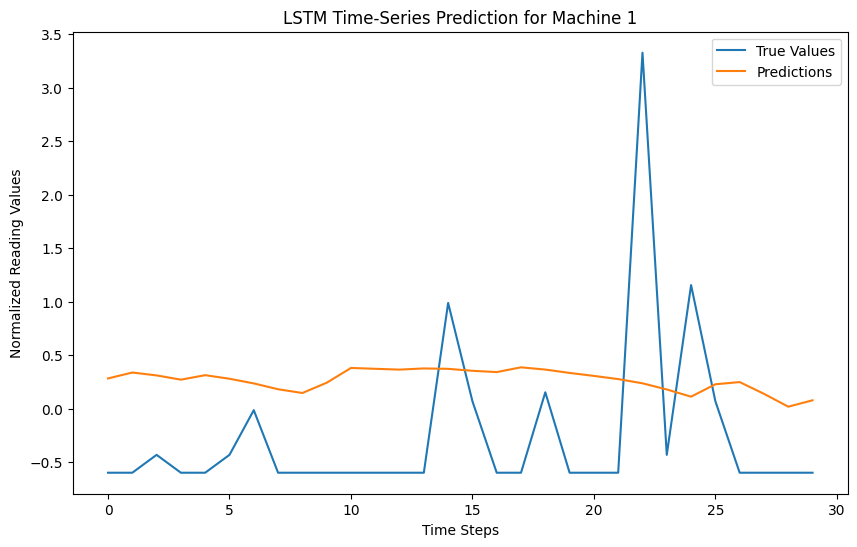

In [4]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Reading Values')
plt.title('LSTM Time-Series Prediction for Machine 1')
plt.legend()
plt.show()
